### 1.1 Problem

This is a supervised classification machine learning task. The objective is to use historical financial and socioeconomic data to predict whether or not an applicant will be able to repay a loan.

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan i.e defaulter)

**SOME OF HYPOTHESIS**

**AGE:-** Are young clients more likely to be defaulters?

**OCCUPATION:-** Are people with work in smaller positions more likely to be defaulter?

**CITY TYPE:-** Are people who belongs to rural areas(eg.farmers) more likely to be defaulters?

**INCOME:-** Are people with lower income brackets more likely to be defaulters?

**DEPENDENTS:-** Are people with dependents more likely to be defaulters?

**FAMILY SIZE:-** Are people with an average family size more than 5 more likely to be defaulters?

**LAST PAYMENTS:-** Are people who are have more last due payments more likely to be defaulters? 

**BRANCH CODE:-** Banks with very few accounts more likely to have less defaulters?

**INTEREST RATE:-** Are people whose interest rate is high more likely to be defaulters?

**LOAN TYPE:-** Are clients with (eg : education) loan more likely to be defaulters?

## Loan Default Prediction

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:.
- 1) willingness to pay and 
- 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

These two fundamental drivers need to be determined at the point of each application to allow the credit grantor to make a calculated decision based on repayment odds, which in turn determines if an applicant should get a loan, and if so - what the size, price and tenure of the offer will be.

There are two types of risk models in general: New business risk, which would be used to assess the risk of application(s) associated with the first loan that he/she applies. The second is a repeat or behaviour risk model, in which case the customer has been a client and applies for a repeat loan. In the latter case - we will have additional performance on how he/she repaid their prior loans, which we can incorporate into our risk model.

It is your job to predict if a loan was good or bad, i.e. accurately predict binary outcome variable, where Good is 0 and Bad is 1.

### 1.2 Description of the data

There are 3 different datasets for both train and test

#### 1.2.1 Demographic data (traindemographics.csv)
- customerid (Primary key used to merge to other data)
- birthdate (date of birth of the customer)
- bank_account_type (type of primary bank account)
- longitude_gps
- latitude_gps
- bank_name_clients (name of the bank)
- bank_branch_clients (location of the branch - not compulsory - so missing in a lot of the cases)
- employment_status_clients (type of employment that customer has)
- level_of_education_clients (highest level of education)

#### 1.2.2 Performance data (trainperf.csv) : 
This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer.
- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Loan value taken)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees)
- termdays (Term of loan)
- referredby (customerId of the customer that referred this person - is missing, then not referred)
- good_bad_flag (good = settled loan on time; bad = did not settled loan on time) - this is the target variable that we need to predic

#### 1.2.3 Previous loans data (trainprevloans.csv) : 
This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

- customerid (Primary key used to merge to other data)
- systemloanid (The id associated with the particular loan. The same customerId can have multiple systemloanid’s for each loan he/she has taken out)
- loannumber (The number of the loan that you have to predict)
- approveddate (Date that loan was approved)
- creationdate (Date that loan application was created)
- loanamount (Date that loan application was created)
- totaldue (Total repayment required to settle the loan - this is the capital loan value disbursed +interest and fees) termdays (Term of loan)
- closeddate (Date that the loan was settled)
- referredby (customerId of the customer that referred this person - is missing, then not refrerred)
- firstduedate (Date of first payment due in cases where the term is longer than 30 days. So in the case where the term is 60+ days - then there are multiple monthly payments due - and this dates reflects the date of the first payment)
- firstrepaiddate (Actual date that he/she paid the first payment as defined above)

**IMPORT NECESSARY LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import datetime
from scipy import stats


from math import ceil

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')
 
plt.rcParams['figure.figsize'] = (16, 6)

**LOAD ALL THE THREE DATASETS**

In [2]:
demo_data=pd.read_csv("demographics.csv")
performance_data=pd.read_csv("perf.csv")
ploan_data=pd.read_csv("trainprevloans.csv")

**ABOUT DEMOGRAPHICS DATASET i.e demo_data**

In [3]:
demo_data.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [4]:
demo_data.shape

(4346, 9)

In [5]:
demo_data.duplicated().sum()

12

In [6]:
demo_data.drop_duplicates(inplace=True)    # REMOVING DUPLICATE rows

In [7]:
demo_data.shape    #4334 unique rows

(4334, 9)

**ABOUT PERFORMANCE LOAN DATASET i.e performance_data**

In [8]:
performance_data.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [9]:
performance_data.shape   #

(4368, 10)

In [10]:
performance_data.duplicated().sum()

0

In [11]:
performance_data['customerid'].nunique()  #

4368

#That means each row represents unique customers i.e there are 4368 unique customers

**JOINING DEMOGRAPHICS AND PERFORMANCE DATASET**

In [12]:
Loan_data=pd.merge(performance_data,demo_data,how="left",on='customerid')

In [13]:
Loan_data.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,1972-01-15 00:00:00.000000,Other,3.432010,6.433055,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,1985-08-23 00:00:00.000000,Savings,3.885298,7.320700,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,1984-09-18 00:00:00.000000,Other,11.139350,10.292041,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,1977-10-10 00:00:00.000000,Savings,3.985770,7.491708,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,1986-09-07 00:00:00.000000,Other,7.457913,9.076574,GT Bank,NaN,Permanent,Primary


In [14]:
round((Loan_data.isnull().sum()/Loan_data.shape[0])*100,2)        # % of null values

customerid                     0.00
systemloanid                   0.00
loannumber                     0.00
approveddate                   0.00
creationdate                   0.00
loanamount                     0.00
totaldue                       0.00
termdays                       0.00
referredby                    86.56
good_bad_flag                  0.00
birthdate                     25.16
bank_account_type             25.16
longitude_gps                 25.16
latitude_gps                  25.16
bank_name_clients             25.16
bank_branch_clients           99.24
employment_status_clients     36.45
level_of_education_clients    89.86
dtype: float64

In [15]:
Loan_data.dtypes

customerid                     object
systemloanid                    int64
loannumber                      int64
approveddate                   object
creationdate                   object
loanamount                    float64
totaldue                      float64
termdays                        int64
referredby                     object
good_bad_flag                  object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

In [16]:
Loan_data.shape

(4368, 18)

# UNIVARIATE ANALYSIS

**--customerid**

In [17]:
#Unique values in customerid
Loan_data['customerid'].nunique()   

4368

customerid is the unique id given to each indivual customer. So there is not anything to analyse in this column and we can drop it for the modeling part.

**--systemloanid**

In [18]:
#Unique values in systemloanid
Loan_data['systemloanid'].nunique()

4368

Again, for the systemloanid the number of unique values is exactly similar to the number of rows. We can't use this for our modeling.

**--loannumber**

In [19]:
#Unique values in loan number
Loan_data['loannumber'].nunique()

23

In [20]:
def bar_plot(data,column):
    plt.figure(figsize=(12,6))
    g=sns.countplot(x=data[column],data=data)
    for i in g.patches:
            g.annotate(s='{:.0f}'.format(i.get_height()), xy=(i.get_x()+0.2, i.get_height()+1))
    plt.title("Count Plot For {} ".format(column))
    plt.xticks(rotation=45)
    plt.tight_layout()

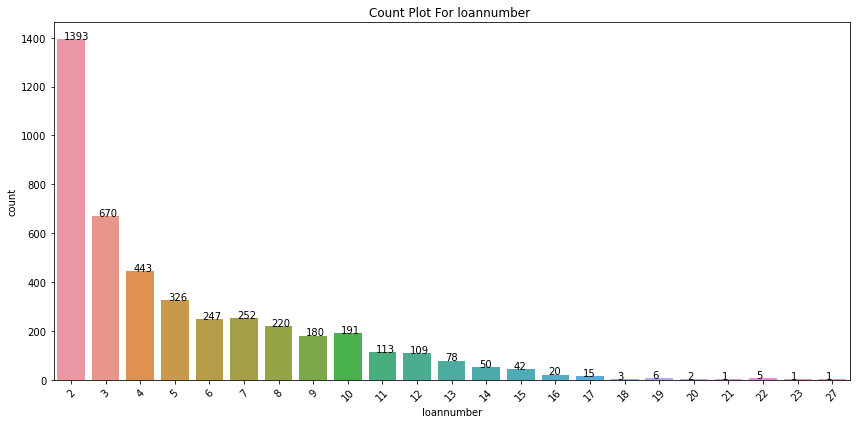

In [21]:
bar_plot(Loan_data,'loannumber')

**OBSERVATIONS:**

: No customer is applying loan for the first time.
: There are few customers who are applying loan for 15th or more than that time

**To Check:**

Are customers whose loan number is higher are good ones (applying loan on time)

In [22]:
Loan_data.describe()

,systemloanid,loannumber,loanamount,totaldue,termdays,longitude_gps,latitude_gps
count,4.368000e+03,4368.000000,4368.000000,4368.000000,4368.000000,3269.000000,3269.000000
mean,3.019810e+08,5.172390,17809.065934,21257.377679,29.261676,4.530975,7.290383
std,1.343115e+04,3.653569,10749.694571,11943.510416,11.512519,7.925454,3.269601
min,3.019585e+08,2.000000,10000.000000,10000.000000,15.000000,-118.247009,-33.868818
25%,3.019691e+08,2.000000,10000.000000,13000.000000,30.000000,3.354842,6.473645
50%,3.019801e+08,4.000000,10000.000000,13000.000000,30.000000,3.584222,6.625681
75%,3.019935e+08,7.000000,20000.000000,24500.000000,30.000000,6.439855,7.426745
max,3.020040e+08,27.000000,60000.000000,68100.000000,90.000000,151.209290,71.228069


**--APPROVED DATE AND CREATION DATE**

In [23]:
for i in ['approveddate','creationdate']:
    Loan_data[i]=pd.to_datetime(Loan_data[i])

In [24]:
Loan_data['approveddate'].min(),Loan_data['approveddate'].max()

(Timestamp('2017-07-01 01:35:26'), Timestamp('2017-07-30 22:55:51'))

In [25]:
Loan_data['creationdate'].min(),Loan_data['creationdate'].max()

(Timestamp('2017-07-01 00:35:20'), Timestamp('2017-07-30 21:55:43'))

from both the dates we can conclude that data is of one month

Text(0, 0.5, 'Date')

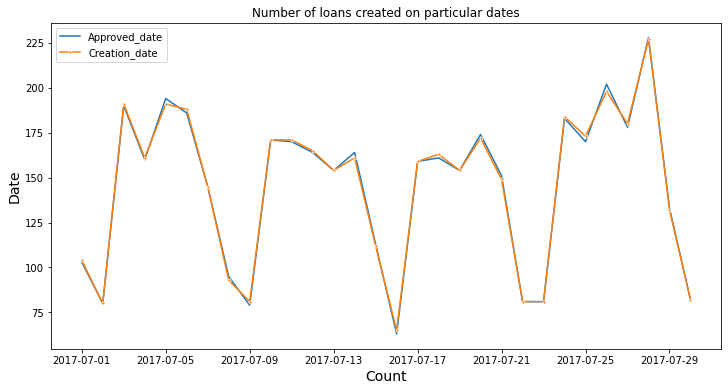

In [26]:
plt.figure(figsize=(12,6))
sns.lineplot(x=Loan_data['approveddate'].dt.date.value_counts().index,y=Loan_data['approveddate'].dt.date.value_counts(),label='Approved_date')
sns.lineplot(x=Loan_data['creationdate'].dt.date.value_counts().index,y=Loan_data['creationdate'].dt.date.value_counts(),label='Creation_date',marker='.')
plt.legend()
plt.title('Number of loans created on particular dates')
plt.xlabel('Count',fontsize=14)
plt.ylabel('Date',fontsize=14)

**CREATING NEW FEATURE APPROVAL TIME**

In [27]:
Loan_data['approval_time'] = round(((Loan_data['approveddate'] - Loan_data['creationdate']).dt.seconds)/3600,2)

In [28]:
# function for easy and efficient analysis of numerical variables
def Kde_plot(data, var_group, bw='scott'):
    
    # Specifing the size of the canvas
    size = len(var_group)
    plt.figure(figsize=(16,6) if size == 1 else (16,size*5),dpi=100)
    sns.set(palette="Set2")
    
    # loop for printing/ploting the descriptive statistics of the numerical variables 
    for j,i in enumerate(var_group):
        
        # calculating the descriptive statistics 
        mini = data[i].min()
        maxi = data[i].max()
        ran  = maxi - mini 
        mean = data[i].mean()
        med  = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        # Calculating the points of standerd daviation 
        points = mean-st_dev, mean+st_dev
        
        # Ploting the variables with every informaton 
        plt.subplot(1 if size==1 else 2,ceil(size/2),j+1)
        sns.kdeplot(data[i],shade=True, bw=bw)
        sns.lineplot(points,[0,0],color='black',label='std_dev')
        sns.scatterplot([mini,maxi],[0,0],color='red',label='min\max')
        sns.scatterplot(mean,[0],color='blue',label='mean')
        sns.scatterplot(med,[0],color='green',label='median')
        plt.xlabel("{}".format(i),fontsize=(14))
        plt.ylabel('density',fontsize=(14))
        plt.tight_layout()
        plt.title('std_dev= {}; kurtosis= {}; skew= {};\nmean= {}; median= {}; range = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                 round(kurt,2),
                                                                                                 round(skew,2),
                                                                                                 round(mean,2),
                                                                                                 round(med,2),
                                                                                                 (round(mini,2),round(maxi,2),round(ran,2))),fontsize=16)
        plt.tight_layout()

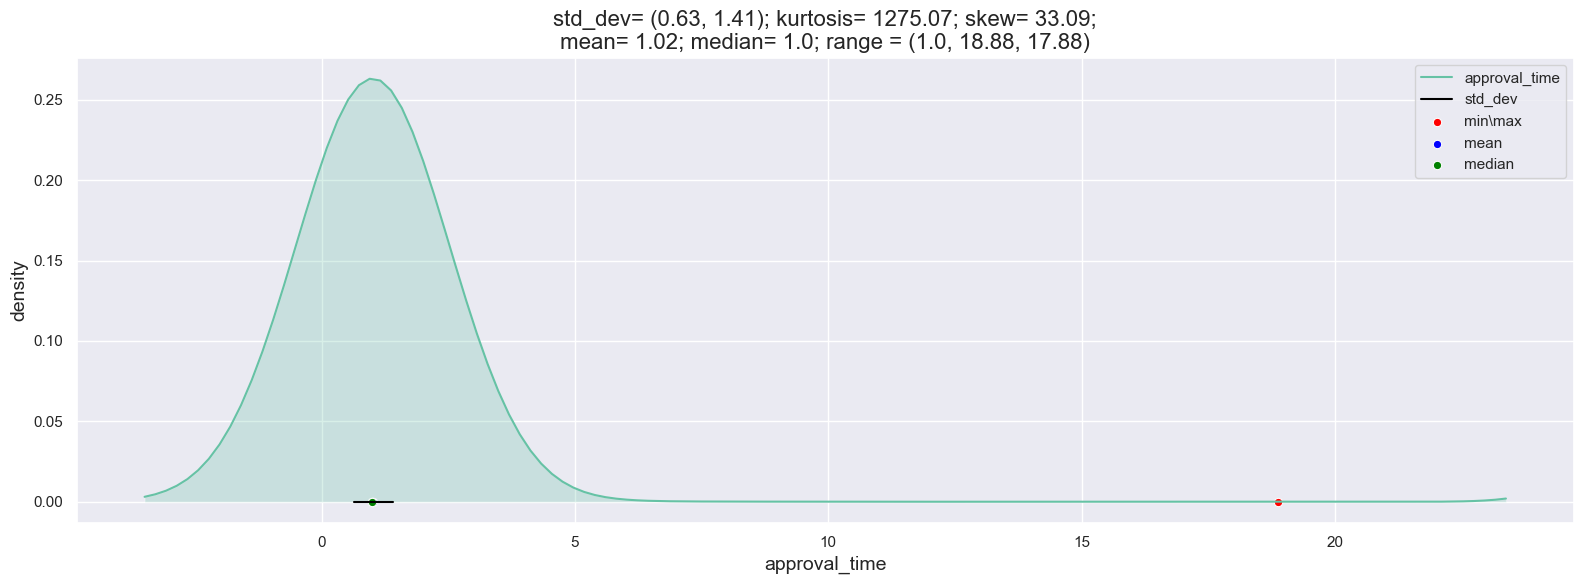

In [29]:
Kde_plot(Loan_data, ['approval_time'],bw=1.5)

In [30]:
Loan_data['approval_time'].sort_values(ascending=False) [:10]

1843    18.88
2450    13.02
4130     9.49
2250     7.39
4089     6.43
2510     5.30
2343     5.05
3267     4.05
3348     4.01
1564     3.27
Name: approval_time, dtype: float64

maximum time taken to approve loan is 18 hours

**Creating new feature creation date day of week**

In [31]:
Loan_data['creationdate_dow'] =Loan_data['creationdate'].dt.dayofweek

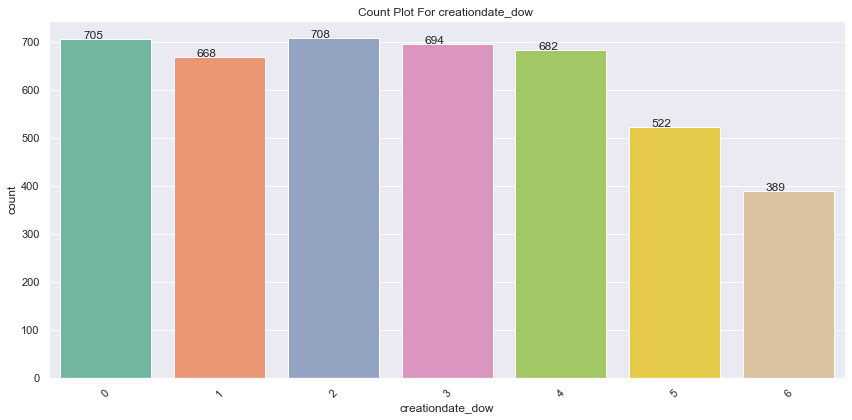

In [32]:
bar_plot(Loan_data,'creationdate_dow')

In [33]:
def Category_plot(data,column):
    day = Loan_data.groupby(column).agg('count').sort_values(by='customerid',ascending=False).index
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.countplot(x=data[column],data=data,order = data[column].value_counts().index)
    plt.subplot(1,2,2)
    plt.pie(data[column].value_counts(), startangle=90,labels=day, autopct='%.1f%%')

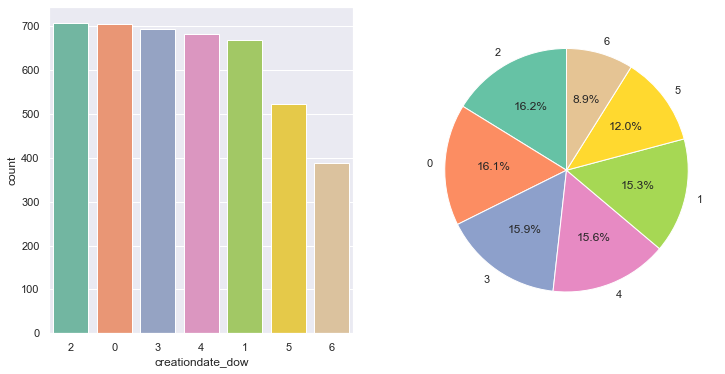

In [34]:
Category_plot(Loan_data,'creationdate_dow')

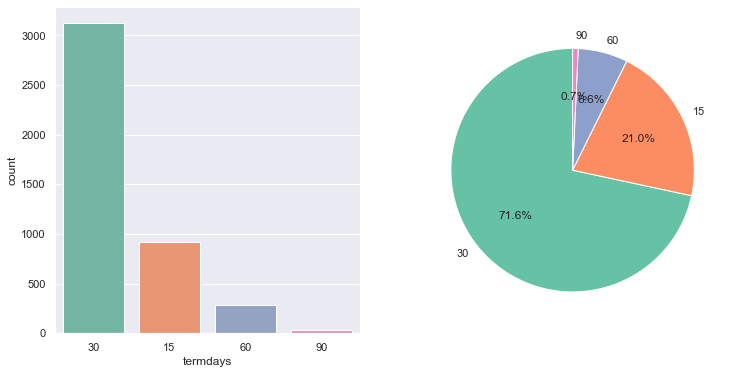

In [35]:
Category_plot(Loan_data,'termdays')

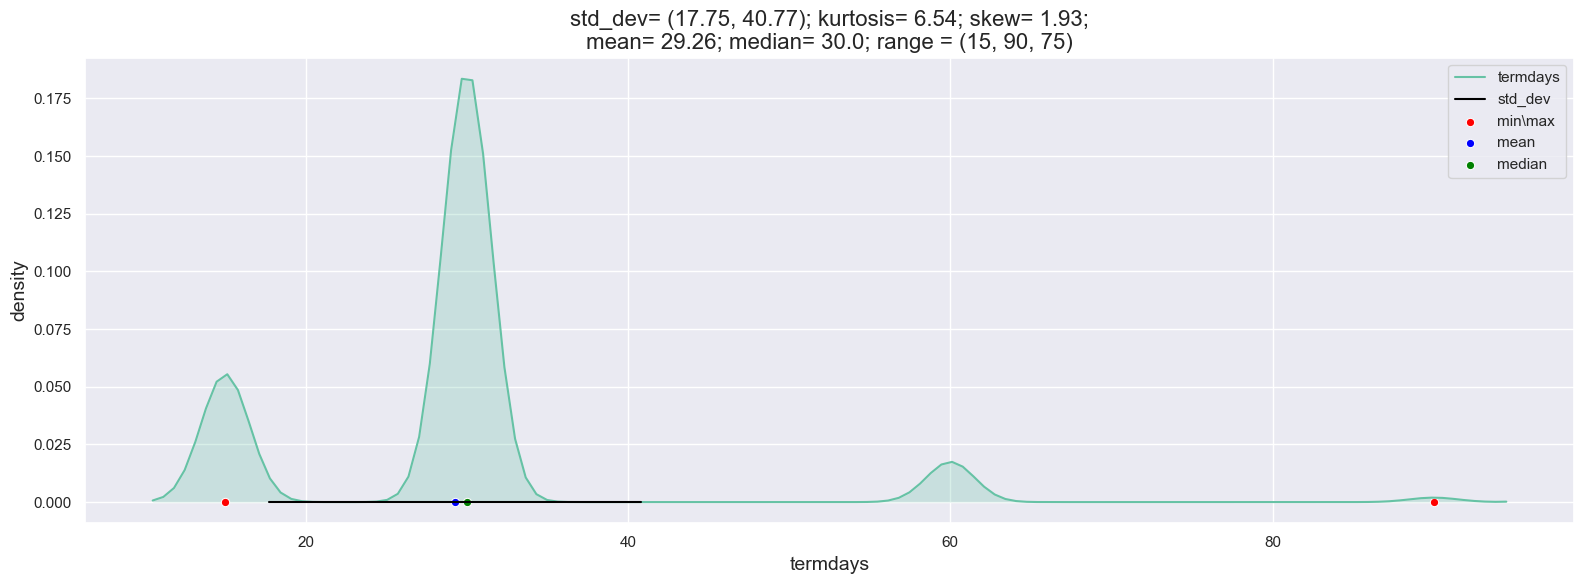

In [36]:
Kde_plot(Loan_data, ['termdays'], bw=1.5)

# loan amount and totaldue

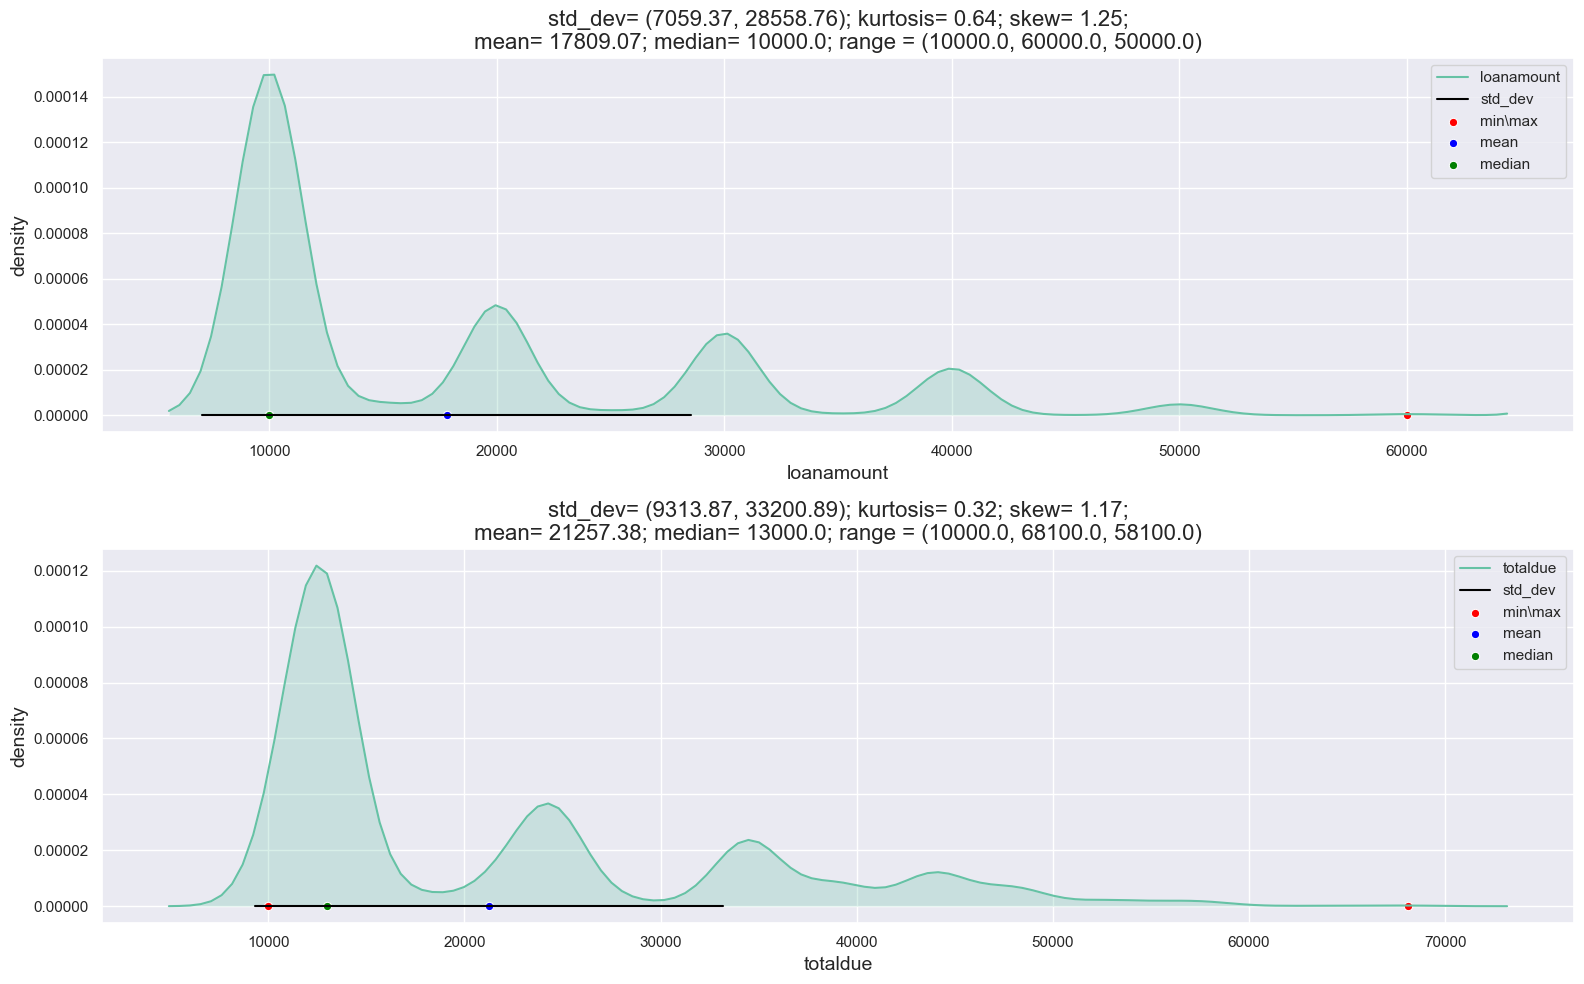

In [37]:
Kde_plot(Loan_data, ['loanamount','totaldue'])

**Creating new variable additional charges**

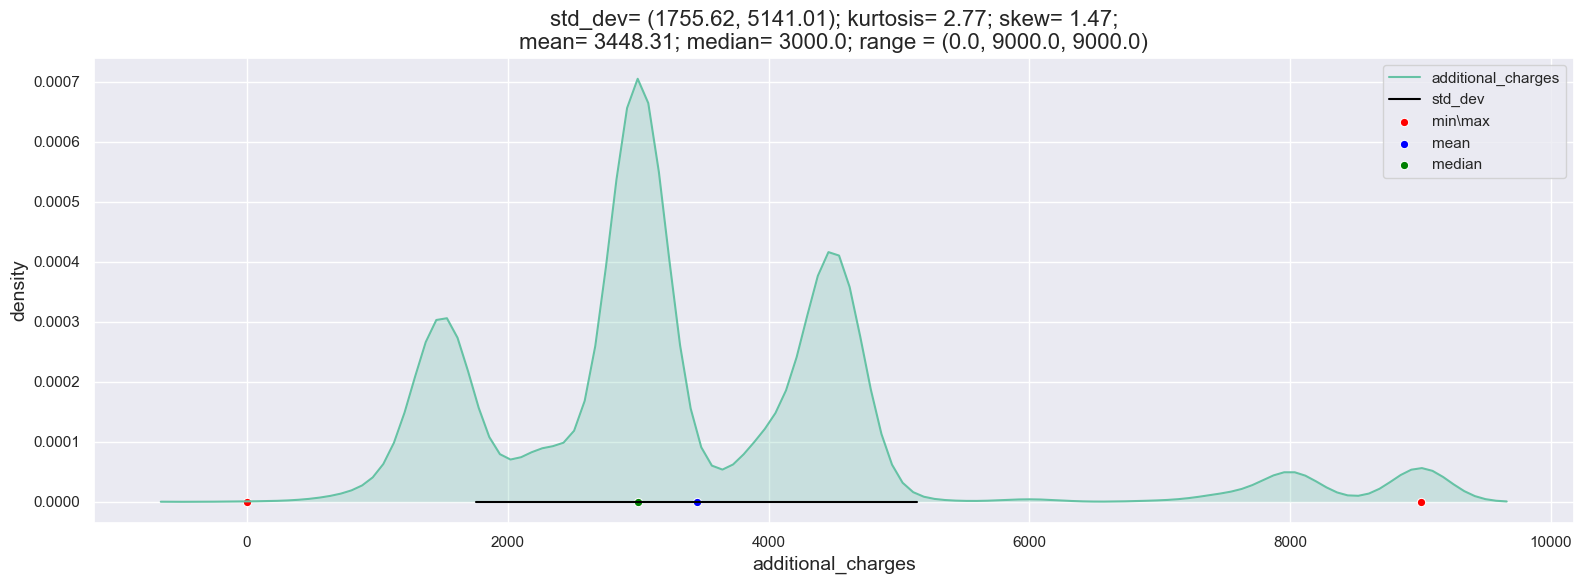

In [38]:
Loan_data['additional_charges'] = Loan_data['totaldue'] - Loan_data['loanamount']
Kde_plot(Loan_data,['additional_charges'])

**Observations:**
* There are few costumers who paid zero additional charges.
* Most customers paid 3000 as the the additional charges.
* From the graph we can also conclude for each customer addtional charges are different even they have applied for similar amount of loan.

**To check:** Relationship between additional charges and loan amount w.r.t target.<br>
**Note:** Try to make new column interest rate.

<AxesSubplot:xlabel='loanamount', ylabel='additional_charges'>

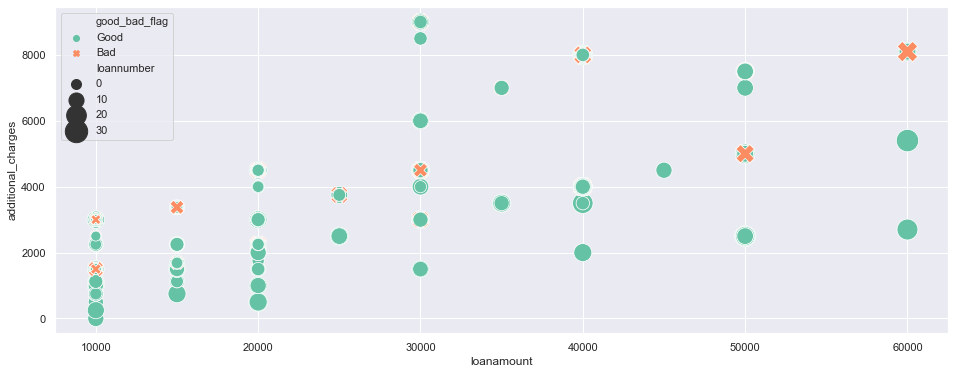

In [39]:
sns.scatterplot(Loan_data['loanamount'], Loan_data['additional_charges'],hue=Loan_data['good_bad_flag'],\
                style=Loan_data['good_bad_flag'],size=Loan_data['loannumber'],sizes=(100,500))

**Creating new variable is_referred**

In [40]:
Loan_data['referredby'].fillna(value='0',inplace=True)
Loan_data['is_referred'] = Loan_data['referredby'].apply(lambda x: 0 if x=='0' else 1)
Loan_data['is_referred'].value_counts()

0    3781
1     587
Name: is_referred, dtype: int64

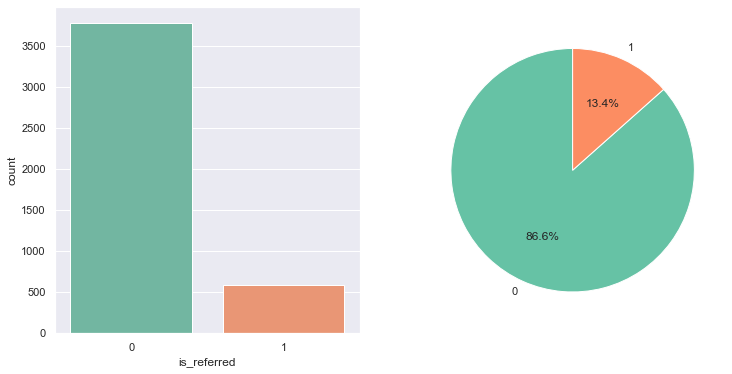

In [41]:
Category_plot(Loan_data,'is_referred')

### birthdate

In [42]:
#Converting birthdate to datetime 
Loan_data['birthdate'] = pd.to_datetime(Loan_data['birthdate'])

* Date variable will not be useful for our analysis.
<br>

**Creating new variable age from birthdate and creation date.**

In [43]:
Loan_data['age'] = round((Loan_data['creationdate'] - Loan_data['birthdate']).dt.days/365.25)

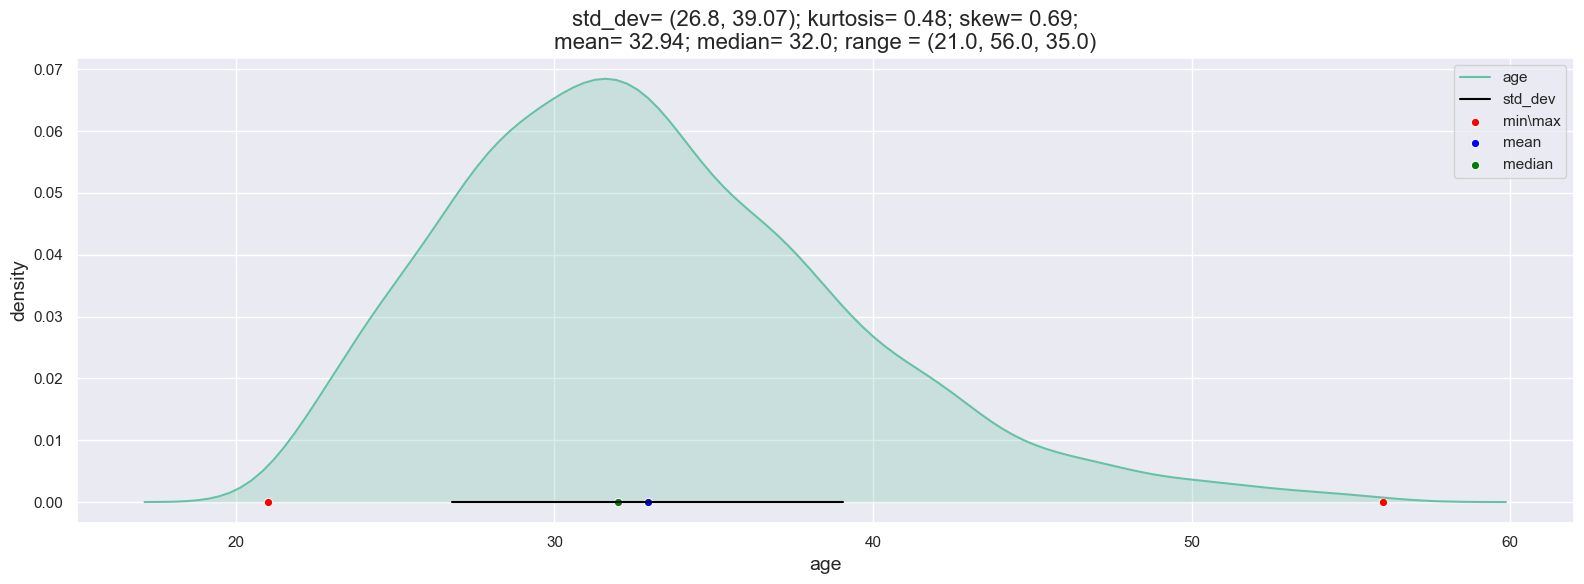

In [44]:
Kde_plot(Loan_data,['age'])

**Prev Loans**

In [45]:
ploan_data['approveddate'] = pd.to_datetime(ploan_data['approveddate'])
ploan_data['creationdate'] = pd.to_datetime(ploan_data['creationdate'])
ploan_data['closeddate'] = pd.to_datetime(ploan_data['closeddate'])
ploan_data['firstduedate'] = pd.to_datetime(ploan_data['firstduedate'])
ploan_data['firstrepaiddate'] = pd.to_datetime(ploan_data['firstrepaiddate'])

In [46]:
for i in ['approveddate', 'creationdate']:
    print('Minimum date for {}: {}'.format(i, min(ploan_data[i])))
    print('Maximum date for {}: {}'.format(i, max(ploan_data[i])))

Minimum date for approveddate: 2016-01-15 08:53:28
Maximum date for approveddate: 2017-07-28 10:47:43
Minimum date for creationdate: 2016-01-15 07:53:17
Maximum date for creationdate: 2017-07-28 09:46:34


In [47]:
ploan_data['approval_time'] = round(((ploan_data['approveddate'] - ploan_data['creationdate']).dt.seconds)/3600,2)

In [48]:
ploan_data['return_days'] = (ploan_data['closeddate'] - ploan_data['approveddate']).dt.days

In [49]:
ploan_data['first_return_days'] = (ploan_data['firstduedate'] - ploan_data['firstrepaiddate']).dt.days

In [50]:
ploan_data['repaid_on_time'] = ploan_data['first_return_days'].apply(lambda x: 1 if x >= 0 else 0)

In [51]:
ploan_data['additional charges'] = ploan_data['totaldue'] - ploan_data['loanamount']

In [52]:
column = ['loanamount', 'totaldue', 'termdays','approval_time',
       'return_days', 'return_days', 'first_return_days','additional charges']

uni_cust_ploan_data = ploan_data['customerid'].value_counts().reset_index().rename(columns={'index':'customerid','customerid':'count'})

for i in column:
    des_col = {'mean': 'ploan_'+i+'_mean', 'min': 'ploan_'+i+'_min', '25%': 'ploan_'+i+'_25%', '50%': 'ploan_'+i+'_50%', '75%': 'ploan_'+i+'_75%', 'max':'ploan_'+i+'_max'}
    describe_data = ploan_data.groupby(by='customerid')[i].describe()[['mean','min','25%','50%','75%','max']].reset_index().rename(columns=des_col)
    uni_cust_ploan_data = uni_cust_ploan_data.merge(right=describe_data, how='left', on='customerid', copy=False)

In [53]:
uni_cust_ploan_data.drop('count', axis=1, inplace=True)

In [54]:
data_com  =Loan_data.merge(uni_cust_ploan_data, how='left', on='customerid', copy=False)

In [55]:
data_com.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,...,ploan_first_return_days_25%,ploan_first_return_days_50%,ploan_first_return_days_75%,ploan_first_return_days_max,ploan_additional charges_mean,ploan_additional charges_min,ploan_additional charges_25%,ploan_additional charges_50%,ploan_additional charges_75%,ploan_additional charges_max
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,0,Good,...,-8.00,4.0,9.50,28.0,3900.0,3000.0,3400.0,3800.0,4500.0,4500.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,0,Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,0,Good,...,-1.00,2.5,6.75,9.0,1750.0,1500.0,1500.0,1500.0,1500.0,3000.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,0,Good,...,-10.25,-8.5,-6.75,-5.0,2250.0,1500.0,1875.0,2250.0,2625.0,3000.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,0,Good,...,0.00,0.5,3.75,7.0,4800.0,3000.0,3000.0,3800.0,5100.0,9000.0


# IMPUTE MISSING VALUES USING IMPUTER

In [56]:
data_com.columns

Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients',
       'approval_time', 'creationdate_dow', 'additional_charges',
       'is_referred', 'age', 'ploan_loanamount_mean', 'ploan_loanamount_min',
       'ploan_loanamount_25%', 'ploan_loanamount_50%', 'ploan_loanamount_75%',
       'ploan_loanamount_max', 'ploan_totaldue_mean', 'ploan_totaldue_min',
       'ploan_totaldue_25%', 'ploan_totaldue_50%', 'ploan_totaldue_75%',
       'ploan_totaldue_max', 'ploan_termdays_mean', 'ploan_termdays_min',
       'ploan_termdays_25%', 'ploan_termdays_50%', 'ploan_termdays_75%',
       'ploan_termdays_max', 'ploan_approval_time_mean',
       'ploan_approval_time_min', 'ploan_approval_time_25%',
       'ploan

'bank_account_type', 'bank_name_clients', 'employment_status_clients'

In [57]:
data_com['bank_account_type'].unique()

array(['Other', 'Savings', nan, 'Current'], dtype=object)

In [58]:
data_com['bank_account_type']=data_com['bank_account_type'].map({'Other':0,'Savings':1,'Current':2})

In [59]:
data_com['bank_name_clients'].fillna(data_com['bank_name_clients'].mode()[0], inplace=True)

In [60]:
data_com['employment_status_clients'].unique()

array(['Permanent', nan, 'Unemployed', 'Self-Employed', 'Student',
       'Retired', 'Contract'], dtype=object)

In [61]:
data_com['employment_status_clients']=data_com['employment_status_clients'].map({'Permanent':0,'Self-Employed':1,'Student':2,'Unemployed':4})

In [62]:
data_imputed_1=data_com[[ 'loannumber','loanamount', 'totaldue', 'termdays', 'bank_account_type', 'longitude_gps',
       'latitude_gps',
       'employment_status_clients', 'creationdate_dow', 'additional_charges',
       'is_referred', 'age', 'ploan_loanamount_mean',
       'ploan_loanamount_min', 'ploan_loanamount_25%', 'ploan_loanamount_50%',
       'ploan_loanamount_75%', 'ploan_loanamount_max', 'ploan_totaldue_mean',
       'ploan_totaldue_min', 'ploan_totaldue_25%', 'ploan_totaldue_50%',
       'ploan_totaldue_75%', 'ploan_totaldue_max', 'ploan_termdays_mean',
       'ploan_termdays_min', 'ploan_termdays_25%', 'ploan_termdays_50%',
       'ploan_termdays_75%', 'ploan_termdays_max', 'ploan_approval_time_mean',
       'ploan_approval_time_min', 'ploan_approval_time_25%',
       'ploan_approval_time_50%', 'ploan_approval_time_75%',
       'ploan_approval_time_max', 'ploan_return_days_mean_x',
       'ploan_return_days_min_x', 'ploan_return_days_25%_x',
       'ploan_return_days_50%_x', 'ploan_return_days_75%_x',
       'ploan_return_days_max_x', 'ploan_return_days_mean_y',
       'ploan_return_days_min_y', 'ploan_return_days_25%_y',
       'ploan_return_days_50%_y', 'ploan_return_days_75%_y',
       'ploan_return_days_max_y', 'ploan_first_return_days_mean',
       'ploan_first_return_days_min', 'ploan_first_return_days_25%',
       'ploan_first_return_days_50%', 'ploan_first_return_days_75%',
       'ploan_first_return_days_max', 'ploan_additional charges_mean',
       'ploan_additional charges_min', 'ploan_additional charges_25%',
       'ploan_additional charges_50%', 'ploan_additional charges_75%',
       'ploan_additional charges_max']]

In [63]:
data_imputed_1

,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,creationdate_dow,additional_charges,...,ploan_first_return_days_25%,ploan_first_return_days_50%,ploan_first_return_days_75%,ploan_first_return_days_max,ploan_additional charges_mean,ploan_additional charges_min,ploan_additional charges_25%,ploan_additional charges_50%,ploan_additional charges_75%,ploan_additional charges_max
0,12,30000.0,34500.0,30,0.0,3.432010,6.433055,0.0,1,4500.0,...,-8.00,4.0,9.50,28.0,3900.000000,3000.0,3400.0,3800.0,4500.0,4500.0
1,2,15000.0,17250.0,30,1.0,3.885298,7.320700,0.0,2,2250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,20000.0,22250.0,15,0.0,11.139350,10.292041,0.0,3,2250.0,...,-1.00,2.5,6.75,9.0,1750.000000,1500.0,1500.0,1500.0,1500.0,3000.0
3,3,10000.0,11500.0,15,1.0,3.985770,7.491708,0.0,3,1500.0,...,-10.25,-8.5,-6.75,-5.0,2250.000000,1500.0,1875.0,2250.0,2625.0,3000.0
4,9,40000.0,44000.0,30,0.0,7.457913,9.076574,0.0,0,4000.0,...,0.00,0.5,3.75,7.0,4800.000000,3000.0,3000.0,3800.0,5100.0,9000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,2,10000.0,13000.0,30,NaN,NaN,NaN,NaN,6,3000.0,...,-6.00,-6.0,-6.00,-6.0,3000.000000,3000.0,3000.0,3000.0,3000.0,3000.0
4364,2,10000.0,13000.0,30,1.0,4.607358,8.460608,0.0,3,3000.0,...,3.00,3.0,3.00,3.0,3000.000000,3000.0,3000.0,3000.0,3000.0,3000.0
4365,3,10000.0,11500.0,15,1.0,3.976842,7.409129,0.0,1,1500.0,...,-13.00,-9.0,-5.00,-1.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0
4366,2,10000.0,13000.0,30,1.0,3.986089,7.386796,0.0,4,3000.0,...,-1.00,-1.0,-1.00,-1.0,3000.000000,3000.0,3000.0,3000.0,3000.0,3000.0


In [64]:
data_imputed_1.isnull().sum()

loannumber                          0
loanamount                          0
totaldue                            0
termdays                            0
bank_account_type                1099
longitude_gps                    1099
latitude_gps                     1099
employment_status_clients        1597
creationdate_dow                    0
additional_charges                  0
is_referred                         0
age                              1099
ploan_loanamount_mean               9
ploan_loanamount_min                9
ploan_loanamount_25%                9
ploan_loanamount_50%                9
ploan_loanamount_75%                9
ploan_loanamount_max                9
ploan_totaldue_mean                 9
ploan_totaldue_min                  9
ploan_totaldue_25%                  9
ploan_totaldue_50%                  9
ploan_totaldue_75%                  9
ploan_totaldue_max                  9
ploan_termdays_mean                 9
ploan_termdays_min                  9
ploan_termda

In [65]:
from sklearn.impute import KNNImputer

In [66]:
imputer = KNNImputer(n_neighbors= 2)
impute_with_2 = imputer.fit_transform(data_imputed_1)

In [67]:
impute_with_2=pd.DataFrame(impute_with_2,columns=['loannumber','loanamount', 'totaldue', 'termdays', 'bank_account_type', 'longitude_gps','latitude_gps','employment_status_clients', 'creationdate_dow', 'additional_charges','is_referred', 'age', 'ploan_loanamount_mean','ploan_loanamount_min', 'ploan_loanamount_25%', 'ploan_loanamount_50%',
       'ploan_loanamount_75%', 'ploan_loanamount_max', 'ploan_totaldue_mean','ploan_totaldue_min', 'ploan_totaldue_25%', 'ploan_totaldue_50%','ploan_totaldue_75%', 'ploan_totaldue_max', 'ploan_termdays_mean','ploan_termdays_min', 'ploan_termdays_25%', 'ploan_termdays_50%',
       'ploan_termdays_75%', 'ploan_termdays_max', 'ploan_approval_time_mean','ploan_approval_time_min', 'ploan_approval_time_25%','ploan_approval_time_50%', 'ploan_approval_time_75%','ploan_approval_time_max', 'ploan_return_days_mean_x','ploan_return_days_min_x', 'ploan_return_days_25%_x','ploan_return_days_50%_x', 'ploan_return_days_75%_x','ploan_return_days_max_x', 'ploan_return_days_mean_y',
       'ploan_return_days_min_y', 'ploan_return_days_25%_y',
       'ploan_return_days_50%_y', 'ploan_return_days_75%_y',
       'ploan_return_days_max_y', 'ploan_first_return_days_mean',
       'ploan_first_return_days_min', 'ploan_first_return_days_25%',
       'ploan_first_return_days_50%', 'ploan_first_return_days_75%',
       'ploan_first_return_days_max', 'ploan_additional charges_mean',
       'ploan_additional charges_min', 'ploan_additional charges_25%',
       'ploan_additional charges_50%', 'ploan_additional charges_75%',
       'ploan_additional charges_max'])

In [68]:
impute_with_2

,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,creationdate_dow,additional_charges,...,ploan_first_return_days_25%,ploan_first_return_days_50%,ploan_first_return_days_75%,ploan_first_return_days_max,ploan_additional charges_mean,ploan_additional charges_min,ploan_additional charges_25%,ploan_additional charges_50%,ploan_additional charges_75%,ploan_additional charges_max
0,12.0,30000.0,34500.0,30.0,0.0,3.432010,6.433055,0.0,1.0,4500.0,...,-8.00,4.0,9.50,28.0,3900.000000,3000.0,3400.000,3800.00,4500.00,4500.0
1,2.0,15000.0,17250.0,30.0,1.0,3.885298,7.320700,0.0,2.0,2250.0,...,0.00,0.5,1.50,5.0,2871.130952,1475.0,1546.875,2693.75,4181.25,4450.0
2,7.0,20000.0,22250.0,15.0,0.0,11.139350,10.292041,0.0,3.0,2250.0,...,-1.00,2.5,6.75,9.0,1750.000000,1500.0,1500.000,1500.00,1500.00,3000.0
3,3.0,10000.0,11500.0,15.0,1.0,3.985770,7.491708,0.0,3.0,1500.0,...,-10.25,-8.5,-6.75,-5.0,2250.000000,1500.0,1875.000,2250.00,2625.00,3000.0
4,9.0,40000.0,44000.0,30.0,0.0,7.457913,9.076574,0.0,0.0,4000.0,...,0.00,0.5,3.75,7.0,4800.000000,3000.0,3000.000,3800.00,5100.00,9000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,2.0,10000.0,13000.0,30.0,1.0,4.965255,5.881324,0.0,6.0,3000.0,...,-6.00,-6.0,-6.00,-6.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0
4364,2.0,10000.0,13000.0,30.0,1.0,4.607358,8.460608,0.0,3.0,3000.0,...,3.00,3.0,3.00,3.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0
4365,3.0,10000.0,11500.0,15.0,1.0,3.976842,7.409129,0.0,1.0,1500.0,...,-13.00,-9.0,-5.00,-1.0,1500.000000,1500.0,1500.000,1500.00,1500.00,1500.0
4366,2.0,10000.0,13000.0,30.0,1.0,3.986089,7.386796,0.0,4.0,3000.0,...,-1.00,-1.0,-1.00,-1.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0


In [69]:
impute_with_2.columns

Index(['loannumber', 'loanamount', 'totaldue', 'termdays', 'bank_account_type',
       'longitude_gps', 'latitude_gps', 'employment_status_clients',
       'creationdate_dow', 'additional_charges', 'is_referred', 'age',
       'ploan_loanamount_mean', 'ploan_loanamount_min', 'ploan_loanamount_25%',
       'ploan_loanamount_50%', 'ploan_loanamount_75%', 'ploan_loanamount_max',
       'ploan_totaldue_mean', 'ploan_totaldue_min', 'ploan_totaldue_25%',
       'ploan_totaldue_50%', 'ploan_totaldue_75%', 'ploan_totaldue_max',
       'ploan_termdays_mean', 'ploan_termdays_min', 'ploan_termdays_25%',
       'ploan_termdays_50%', 'ploan_termdays_75%', 'ploan_termdays_max',
       'ploan_approval_time_mean', 'ploan_approval_time_min',
       'ploan_approval_time_25%', 'ploan_approval_time_50%',
       'ploan_approval_time_75%', 'ploan_approval_time_max',
       'ploan_return_days_mean_x', 'ploan_return_days_min_x',
       'ploan_return_days_25%_x', 'ploan_return_days_50%_x',
       'ploan_return

In [70]:
data_model=data_com[['good_bad_flag','bank_name_clients']]

In [71]:
pp2=pd.concat([impute_with_2, data_model], axis=1)

In [72]:
pp2

,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,creationdate_dow,additional_charges,...,ploan_first_return_days_75%,ploan_first_return_days_max,ploan_additional charges_mean,ploan_additional charges_min,ploan_additional charges_25%,ploan_additional charges_50%,ploan_additional charges_75%,ploan_additional charges_max,good_bad_flag,bank_name_clients
0,12.0,30000.0,34500.0,30.0,0.0,3.432010,6.433055,0.0,1.0,4500.0,...,9.50,28.0,3900.000000,3000.0,3400.000,3800.00,4500.00,4500.0,Good,Diamond Bank
1,2.0,15000.0,17250.0,30.0,1.0,3.885298,7.320700,0.0,2.0,2250.0,...,1.50,5.0,2871.130952,1475.0,1546.875,2693.75,4181.25,4450.0,Good,GT Bank
2,7.0,20000.0,22250.0,15.0,0.0,11.139350,10.292041,0.0,3.0,2250.0,...,6.75,9.0,1750.000000,1500.0,1500.000,1500.00,1500.00,3000.0,Good,EcoBank
3,3.0,10000.0,11500.0,15.0,1.0,3.985770,7.491708,0.0,3.0,1500.0,...,-6.75,-5.0,2250.000000,1500.0,1875.000,2250.00,2625.00,3000.0,Good,First Bank
4,9.0,40000.0,44000.0,30.0,0.0,7.457913,9.076574,0.0,0.0,4000.0,...,3.75,7.0,4800.000000,3000.0,3000.000,3800.00,5100.00,9000.0,Good,GT Bank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,2.0,10000.0,13000.0,30.0,1.0,4.965255,5.881324,0.0,6.0,3000.0,...,-6.00,-6.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0,Bad,GT Bank
4364,2.0,10000.0,13000.0,30.0,1.0,4.607358,8.460608,0.0,3.0,3000.0,...,3.00,3.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0,Bad,FCMB
4365,3.0,10000.0,11500.0,15.0,1.0,3.976842,7.409129,0.0,1.0,1500.0,...,-5.00,-1.0,1500.000000,1500.0,1500.000,1500.00,1500.00,1500.0,Bad,First Bank
4366,2.0,10000.0,13000.0,30.0,1.0,3.986089,7.386796,0.0,4.0,3000.0,...,-1.00,-1.0,3000.000000,3000.0,3000.000,3000.00,3000.00,3000.0,Bad,Skye Bank


In [73]:
pp2=pd.get_dummies(data=pp2, columns=['bank_name_clients'], drop_first=True)

In [74]:
pp2

,loannumber,loanamount,totaldue,termdays,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,creationdate_dow,additional_charges,...,bank_name_clients_Keystone Bank,bank_name_clients_Skye Bank,bank_name_clients_Stanbic IBTC,bank_name_clients_Standard Chartered,bank_name_clients_Sterling Bank,bank_name_clients_UBA,bank_name_clients_Union Bank,bank_name_clients_Unity Bank,bank_name_clients_Wema Bank,bank_name_clients_Zenith Bank
0,12.0,30000.0,34500.0,30.0,0.0,3.432010,6.433055,0.0,1.0,4500.0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,15000.0,17250.0,30.0,1.0,3.885298,7.320700,0.0,2.0,2250.0,...,0,0,0,0,0,0,0,0,0,0
2,7.0,20000.0,22250.0,15.0,0.0,11.139350,10.292041,0.0,3.0,2250.0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,10000.0,11500.0,15.0,1.0,3.985770,7.491708,0.0,3.0,1500.0,...,0,0,0,0,0,0,0,0,0,0
4,9.0,40000.0,44000.0,30.0,0.0,7.457913,9.076574,0.0,0.0,4000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,2.0,10000.0,13000.0,30.0,1.0,4.965255,5.881324,0.0,6.0,3000.0,...,0,0,0,0,0,0,0,0,0,0
4364,2.0,10000.0,13000.0,30.0,1.0,4.607358,8.460608,0.0,3.0,3000.0,...,0,0,0,0,0,0,0,0,0,0
4365,3.0,10000.0,11500.0,15.0,1.0,3.976842,7.409129,0.0,1.0,1500.0,...,0,0,0,0,0,0,0,0,0,0
4366,2.0,10000.0,13000.0,30.0,1.0,3.986089,7.386796,0.0,4.0,3000.0,...,0,1,0,0,0,0,0,0,0,0


In [75]:
pp2.to_csv('cleaned_loan.csv') 

# MODELLING

In [75]:
x = pp2.drop(['good_bad_flag'], axis=1)
y = pp2['good_bad_flag'].replace({'Good':0, 'Bad':1})

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=101, test_size=0.2, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [77]:
logreg = LogisticRegression(class_weight= 'balanced')
logreg.fit(x_train, y_train)
train_pred = logreg.predict(x_train)
test_pred = logreg.predict(x_test)

In [80]:
train_predict1 = logreg.predict(x_train)
k = f1_score(train_predict1, y_train)
print('Training f1_score', k )

Training f1_score 0.4623115577889447


In [81]:
test_predict1=logreg.predict(x_test)
# k = f1_score(test_predict1, y_test,average='weighted')
k = f1_score(test_predict1, y_test)
print('Test f1_score', k )

Test f1_score 0.4188679245283019


In [82]:
# Predicting over the Train
train_pred

array([0, 0, 1, ..., 0, 0, 1], dtype=int64)

In [83]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.66      0.88      0.75      2067
           1       0.66      0.35      0.46      1427

    accuracy                           0.66      3494
   macro avg       0.66      0.62      0.61      3494
weighted avg       0.66      0.66      0.64      3494



In [83]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.67      0.85      0.75       534
           1       0.58      0.33      0.42       340

    accuracy                           0.65       874
   macro avg       0.62      0.59      0.58       874
weighted avg       0.63      0.65      0.62       874



In [84]:
confusion_matrix(test_pred, y_test)

array([[455,  79],
       [229, 111]], dtype=int64)

In [85]:
cols = x_train.columns

In [86]:
logreg.coef_

array([[-7.91340936e-02, -2.29433179e-01, -1.73776008e-01,
         2.02924094e-01,  1.57669841e-01,  5.24870774e-03,
         6.81559795e-02, -2.54976375e-03,  6.73357547e-02,
         2.31126621e-01, -2.06175458e-02, -1.05718815e-01,
         3.51114505e-01, -4.98910041e-01, -1.51215657e-01,
        -1.25531898e-01, -1.91535537e-01, -6.80750836e-02,
         3.32229785e-01,  6.70063252e-01,  2.98046492e-01,
        -1.16273633e-01, -7.07919475e-02,  1.03941137e-02,
         8.45447307e-01, -3.91207286e-01, -3.23791882e-01,
        -1.89477321e-01, -2.79516467e-01,  1.40567570e-01,
         1.22288297e-01, -1.53970370e-01,  2.16829949e-01,
         3.32802449e-01, -4.37222350e-01, -2.36556931e-01,
        -6.15379235e-02,  1.42069406e-01, -7.59659967e-02,
        -3.25917934e-02,  6.68005221e-02, -2.22301508e-02,
        -6.15379235e-02,  1.42069406e-01, -7.59659967e-02,
        -3.25917934e-02,  6.68005221e-02, -2.22301508e-02,
         2.55800174e-02, -3.01379619e-01, -3.91254025e-0

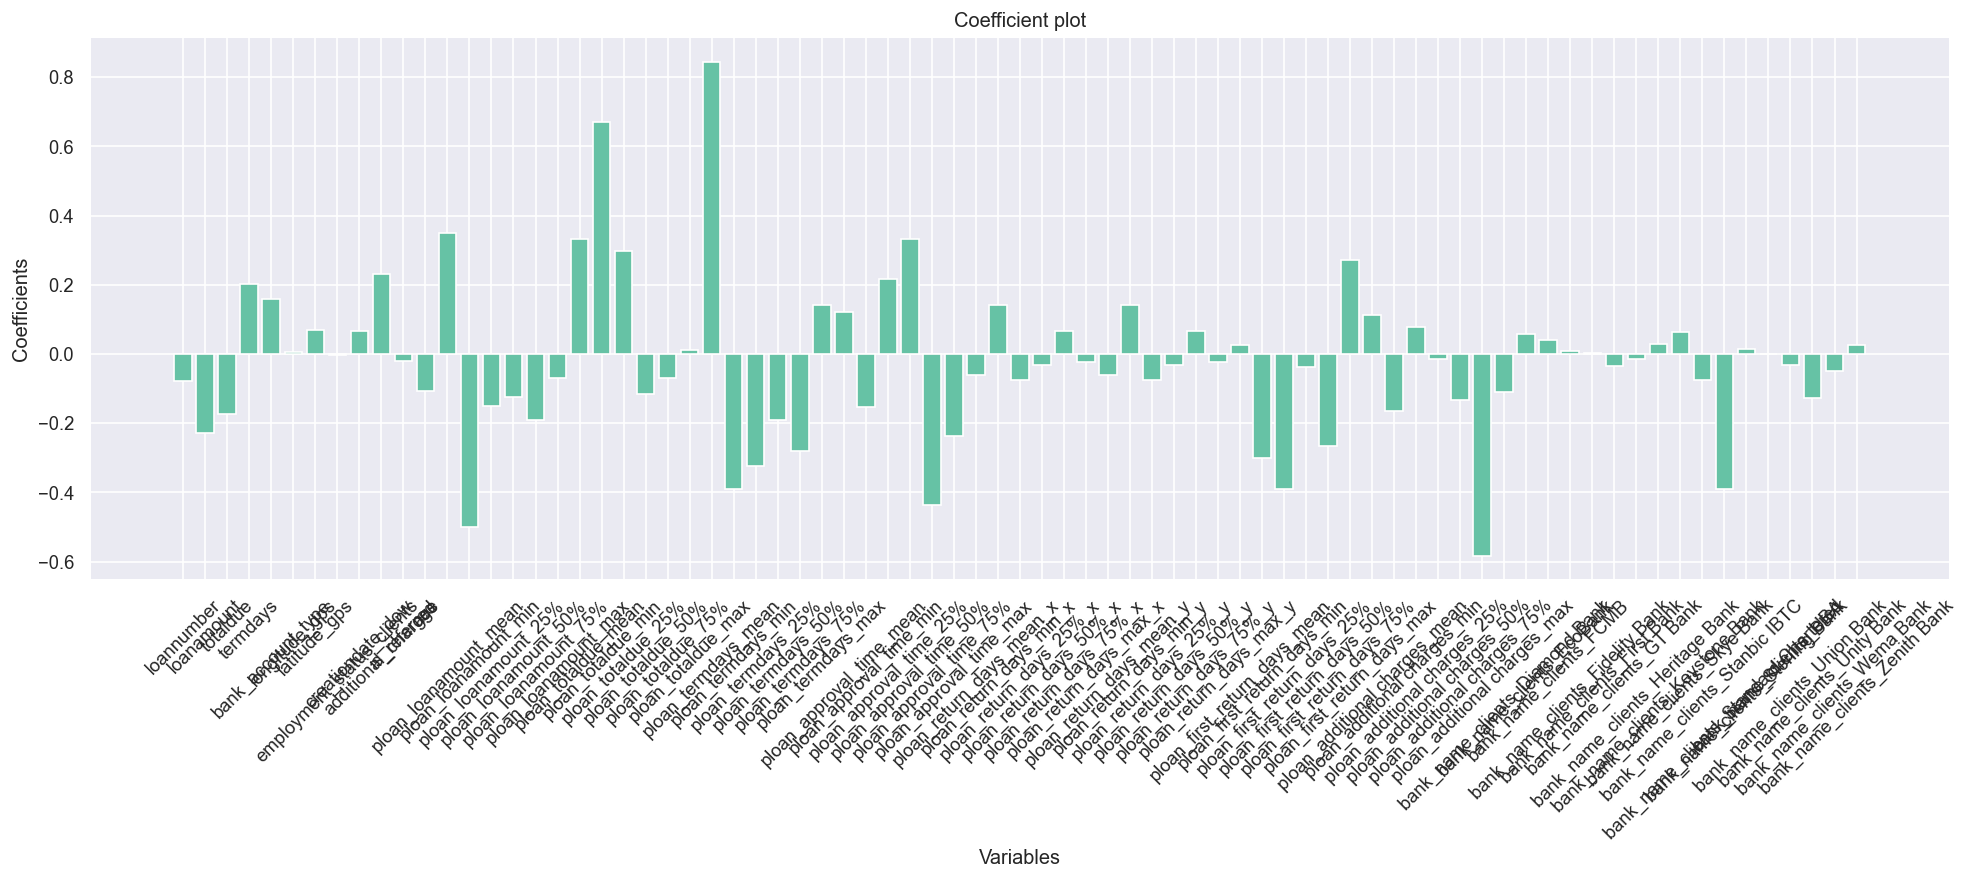

In [87]:
plt.figure(figsize=(20, 6), dpi=120, facecolor='w', edgecolor='b')
x = cols
c = logreg.coef_.reshape(-1)
plt.bar( x, c )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')
plt.xticks(rotation = 45)
plt.show()

In [88]:
Coefficients = pd.DataFrame({
    'Variable'    : x_train.columns,
    'coefficient' : abs(c)
})
Coefficients.head()

,Variable,coefficient
0,loannumber,0.079134
1,loanamount,0.229433
2,totaldue,0.173776
3,termdays,0.202924
4,bank_account_type,0.157670


In [103]:
#selecting variables with high coefficient
sig_var = Coefficients[Coefficients.coefficient > 0.3]

In [104]:
subset = pp2[sig_var['Variable'].values]
subset.head()

,ploan_loanamount_mean,ploan_loanamount_min,ploan_totaldue_mean,ploan_totaldue_min,ploan_termdays_mean,ploan_termdays_min,ploan_termdays_25%,ploan_approval_time_50%,ploan_approval_time_75%,ploan_first_return_days_min,ploan_first_return_days_25%,ploan_additional charges_max,bank_name_clients_Standard Chartered
0,18181.818182,10000.0,22081.818182,13000.0,30.000000,30.0,30.00,1.0,1.0,-40.0,-8.00,4500.0,0
1,18511.904762,10000.0,21383.035714,11475.0,21.964286,15.0,15.00,1.0,1.0,-1.0,0.00,4450.0,0
2,10000.000000,10000.0,11750.000000,11500.0,17.500000,15.0,15.00,1.0,1.0,-31.0,-1.00,3000.0,0
3,10000.000000,10000.0,12250.000000,11500.0,22.500000,15.0,18.75,1.0,1.0,-12.0,-10.25,3000.0,0
4,18750.000000,10000.0,23550.000000,13000.0,37.500000,30.0,30.00,1.0,1.0,0.0,0.00,9000.0,0


In [105]:
# Using train test split function
train_x,test_x,train_y,test_y = train_test_split(subset, y, random_state = 56)

In [106]:
# Creating instance of Logistic Regresssion
logreg = LogisticRegression()

# Fitting the model
logreg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
# Predicting over the Train
train_predict = logreg.predict(train_x)
k = f1_score(train_predict, train_y)
print('Training f1_score', k )

Training f1_score 0.21759259259259256


In [108]:
test_predict=logreg.predict(test_x)
k = f1_score(test_predict, test_y)
print('Testing f1_score', k )

Testing f1_score 0.18248175182481752


Text(0.5, 1.0, 'Coefficient plot')

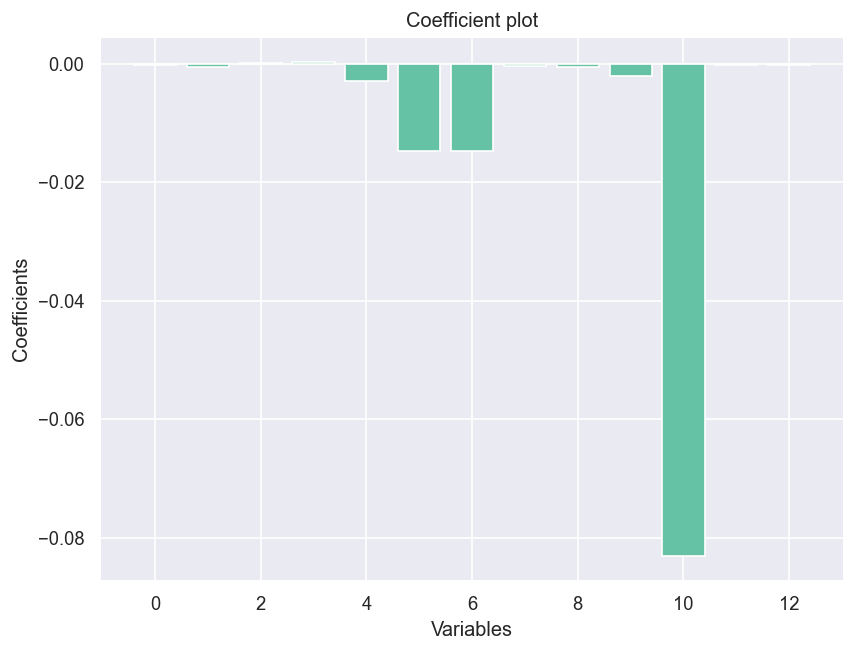

In [109]:
plt.figure(figsize=(8, 6), dpi=120, facecolor='w', edgecolor='b')
x = range(len(train_x.columns))
c = logreg.coef_.reshape(-1)
plt.bar( x, c )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')

# REGULARISATION

--Lasso

In [75]:
x = pp2.drop(['good_bad_flag'], axis=1)
y = pp2['good_bad_flag'].replace({'Good':0, 'Bad':1})

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=101, test_size=0.2, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)

x_test_scaled = scaler.transform(x_test)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [109]:
logreg = LogisticRegression(penalty='l1',class_weight= 'balanced',solver='liblinear', C=1)
logreg.fit(x_train, y_train)
train_pred = logreg.predict(x_train)
test_pred = logreg.predict(x_test)

In [110]:
train_predict1 = logreg.predict(x_train)
k = f1_score(train_predict1, y_train)
print('Training f1_score', k )

Training f1_score 0.463794683776352


In [111]:
test_predict1=logreg.predict(x_test)
k = f1_score(test_predict1, y_test)
print('Test f1_score', k )

Test f1_score 0.41132075471698115


In [112]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(train_pred, y_train))

              precision    recall  f1-score   support

           0       0.67      0.88      0.76      2074
           1       0.66      0.36      0.46      1420

    accuracy                           0.67      3494
   macro avg       0.66      0.62      0.61      3494
weighted avg       0.66      0.67      0.64      3494



In [113]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       534
           1       0.57      0.32      0.41       340

    accuracy                           0.64       874
   macro avg       0.62      0.58      0.58       874
weighted avg       0.63      0.64      0.61       874



In [142]:
confusion_matrix(test_pred, y_test)

array([[460,  79],
       [224, 111]], dtype=int64)

In [143]:
cols = x_train.columns

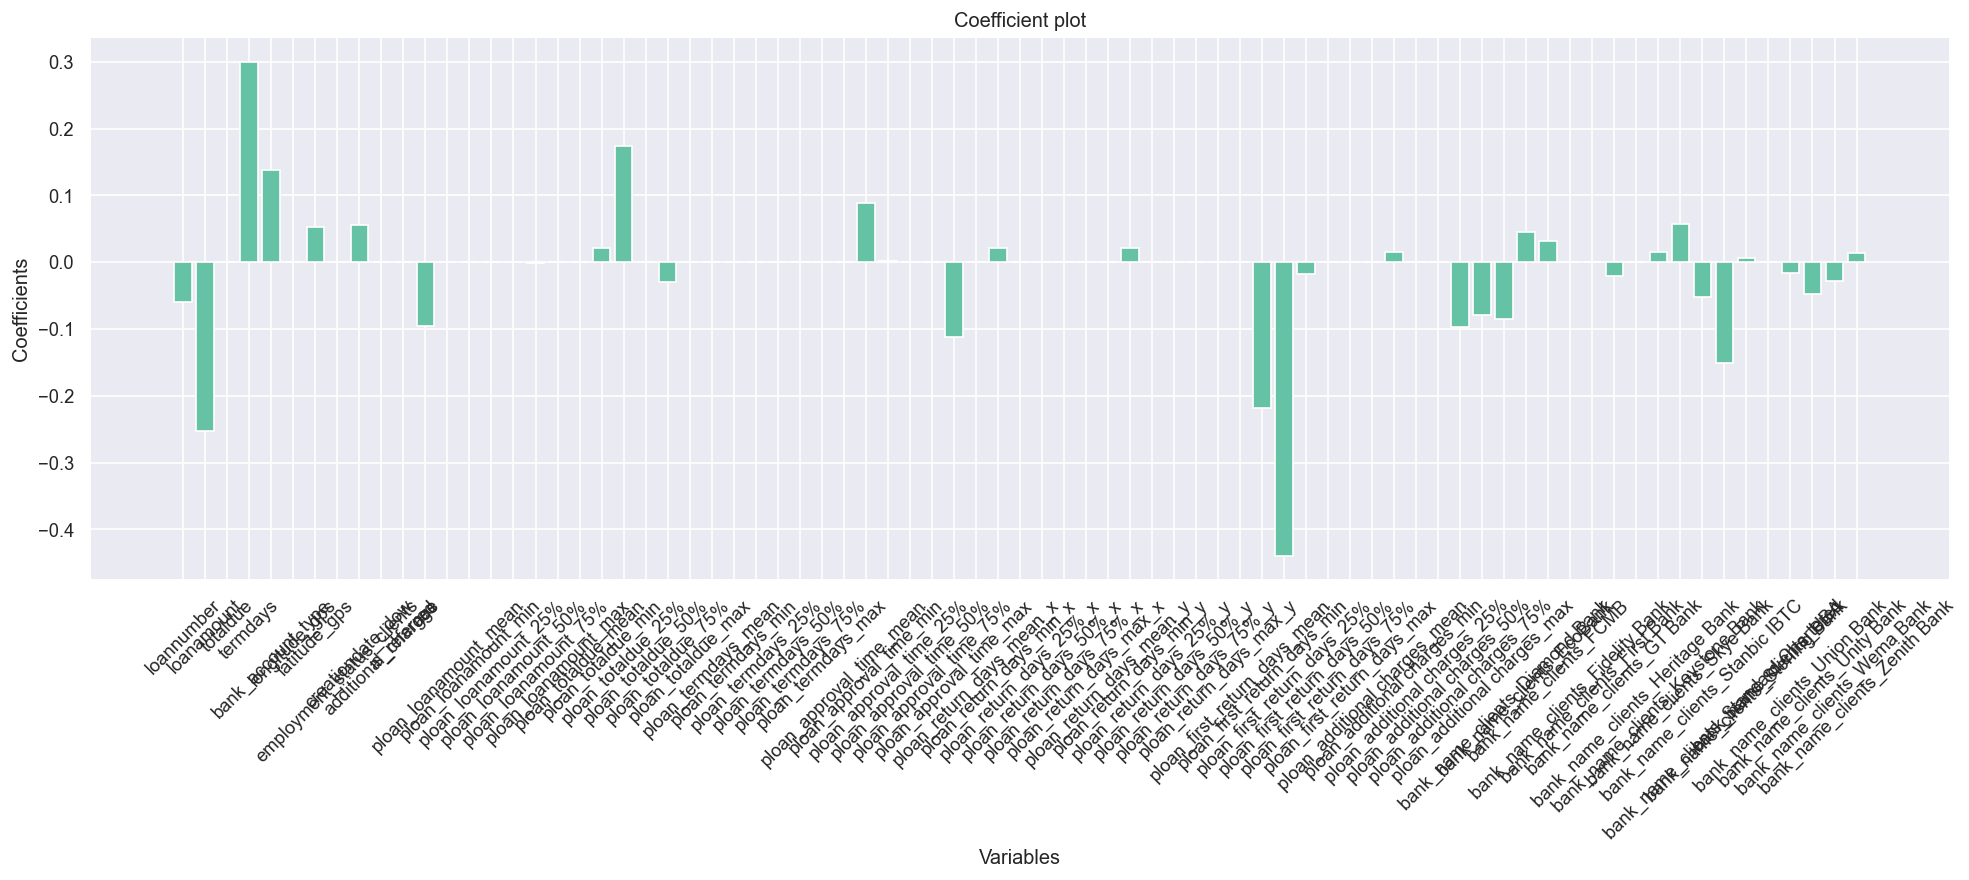

In [144]:
plt.figure(figsize=(20, 6), dpi=120, facecolor='w', edgecolor='b')
x = cols
c = logreg.coef_.reshape(-1)
plt.bar( x, c )
plt.xlabel( "Variables")
plt.ylabel('Coefficients')
plt.title('Coefficient plot')
plt.xticks(rotation = 45)
plt.show()